In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Problem 1. Detecting Objects with Template Matching 

In [2]:
template = cv2.imread('template.jpeg')
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
t_row, t_col = template.shape[0:2]

img = cv2.imread('birds1.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [3]:
def Normalised_Cross_Correlation(roi, target):
    cor = np.sum(roi * target)
    nor = np.sqrt( (np.sum(roi ** 2))) * np.sqrt(np.sum(target ** 2))
    return cor / nor

def template_matching(img, target):
    # initial parameter
    height, width = img.shape
    tar_row, tar_col = target.shape
    (max_Y, max_X) = (0, 0)
    MaxValue = 0

    # Set image, target and result value matrix
    img = np.array(img, dtype="int")
    target = np.array(target, dtype="int")
    ncc_value = np.zeros((height - tar_row, width - tar_col))

    # calculate value using filter-kind operation from top-left to bottom-right
    for y in range(0, height - tar_row):
        for x in range(0, width - tar_col):
            # image roi
            roi = img[y : y + tar_row, x : x + tar_col]
            # calculate ncc value
            ncc_value[y, x] = Normalised_Cross_Correlation(roi, target)
            # find the most match area
            if ncc_value[y, x] > MaxValue:
                MaxValue = ncc_value[y, x]
                max_Y, max_X = y, x

    return max_X, max_Y

In [4]:
top_left = template_matching(img, template)
# draw rectangle on the result region
img_res = cv2.rectangle(img, top_left, (top_left[0] + t_col, top_left[1] + t_row), 255, 3)

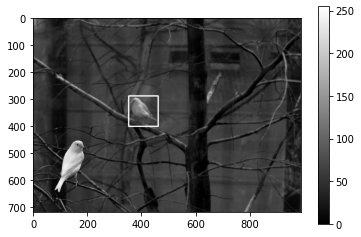

In [5]:
plt.imshow(cv2.rectangle(img_res, top_left, (top_left[0] + t_col, top_left[1] + t_row), 255, 3), cmap = 'gray')
plt.colorbar()

In [6]:
img = cv2.imread('birds2.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

top_left = template_matching(img, template)
# draw rectangle on the result region
img_res = cv2.rectangle(img, top_left, (top_left[0] + t_col, top_left[1] + t_row), 255, 3)

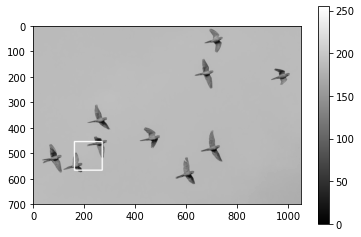

In [7]:
plt.imshow(cv2.rectangle(img_res, top_left, (top_left[0] + t_col, top_left[1] + t_row), 255, 3), cmap = 'gray')
plt.colorbar()

Problem 2. Hough Transform

In [8]:
def hough(image):
    row, col = image.shape
    max_dist = np.ceil(np.sqrt(row ** 2 + col ** 2))   #  diagonal length
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    rhos = np.linspace(-max_dist, max_dist, int(2 * max_dist))
    accumulator = np.zeros(( int(2*max_dist), len(thetas)), dtype=int)
    rows, cols = np.nonzero(image)  # (row, col) indexes to edges

    for i in range(len(rows)):
        r = rows[i] 
        c = cols[i] 
        for t_idx in range(len(thetas)):
            rho = int(round(c*np.cos(thetas)[t_idx] + r*np.sin(thetas)[t_idx]) + max_dist)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def thresholding(HT, thre_theta=None, threshold=None):
    if threshold is None:
        t = 0.75 * np.max(HT)
    rho_max, theta_max = HT.shape[0]/2, HT.shape[1]/2
    parameters = np.argwhere(HT > t)
    parameters[:,0] = parameters[:,0] - rho_max
    parameters[:,1] = theta_max - parameters[:,1]
    lines = []
    for p in parameters:
        rho, theta = p[0], p[1]
        if (thre_theta is None) or ((theta > thre_theta[0]) and (theta < thre_theta[1])):
            x1, x2 = 100*int(round(rho/np.cos(np.deg2rad(theta)))), (-99)*int(round(rho/np.cos(np.deg2rad(theta))))
            y1, y2 = 99*int(round(rho/np.sin(np.deg2rad(theta)))), (-100)*int(round(rho/np.sin(np.deg2rad(theta))))
            lines.append([[x1, x2], [y1, y2]])
    return lines

In [9]:
w, h = 11, 11
test = np.zeros((w,h))
white = [(0,0),(0,-1),(-1,0),(-1,-1),(int(w / 2),int(h / 2))]
for point in white:
    test[point] = 1
accumulator, thetas, rhos = hough(test)
lines = thresholding(accumulator)

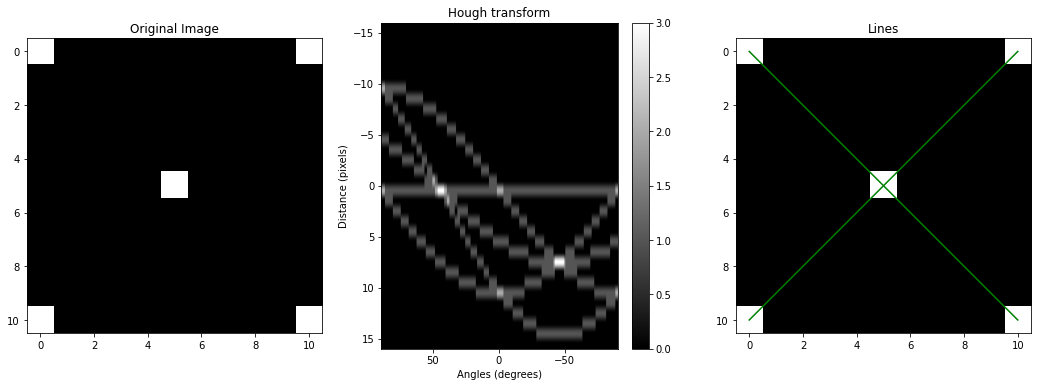

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(test, cmap='gray')
ax[0].set_title('Original Image')

f = ax[1].imshow(accumulator, cmap='gray', extent=[np.rad2deg(thetas[-1]),np.rad2deg(thetas[0]),rhos[-1],rhos[0]])
ax[1].set_aspect('auto')
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
fig.colorbar(f, ax=ax[1])

ax[2].imshow(test, cmap='gray')
ax[2].plot([10,0], [0,10], 'g')
ax[2].plot([0,10], [0,10], 'g')
ax[2].set_title('Lines')

plt.show()

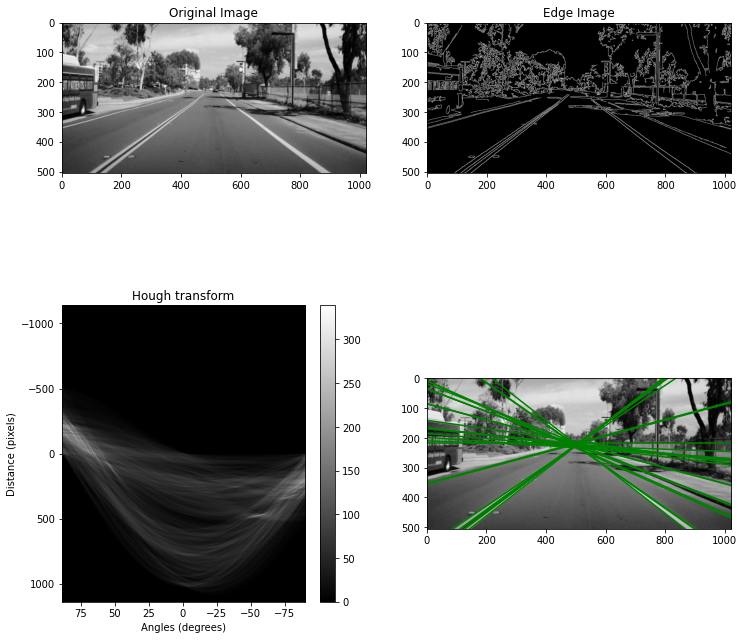

In [11]:
img = cv2.imread('lane.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img, 100, 250)
accumulator, thetas, rhos = hough(edges)
lines = thresholding(accumulator)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0,0].imshow(img, cmap='gray')
ax[0,0].set_title('Original Image')

ax[0,1].imshow(edges, cmap='gray')
ax[0,1].set_title('Edge Image')

f = ax[1,0].imshow(accumulator, cmap='gray', extent=[np.rad2deg(thetas[-1]),np.rad2deg(thetas[0]),rhos[-1],rhos[0]])
ax[1,0].set_aspect('auto')
ax[1,0].set_title('Hough transform')
ax[1,0].set_xlabel('Angles (degrees)')
ax[1,0].set_ylabel('Distance (pixels)')
fig.colorbar(f, ax=ax[1,0])

ax[1,1].imshow(img, cmap='gray')
for l in lines:
    ax[1,1].plot(l[0], l[1], 'g')
ax[1,1].set_xlim(0, img.shape[1])
ax[1,1].set_ylim(img.shape[0], 0)

plt.show()

Theta values are 55 degrees and -54 degrees


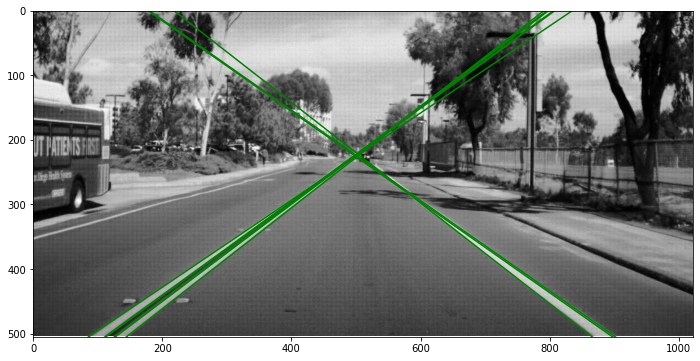

In [12]:
lines = thresholding(accumulator, thre_theta=[-57, 57])
print('Theta values are 55 degrees and -54 degrees')

plt.figure(figsize=(18,6))
plt.imshow(img, cmap='gray')
for l in lines:
    plt.plot(l[0], l[1], 'g')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0], 0)

plt.show()

Problem 3. K-Means Segmentation

In [13]:
def createDataset(img):
    return img.reshape(img.shape[0]*img.shape[1], 3).astype(int)

def kMeansCluster(features, centers):
    iteration = 100
    dist = np.zeros((features.shape[0], centers.shape[0]))
    classes = np.zeros(features.shape[0])
    
    for it in range(iteration):
        # Assignment
        for k in range(centers.shape[0]):
            dist[:,k] = np.linalg.norm(features-centers[k], axis=1)
        classes = np.argmin(dist, axis=1)
        
        # Update
        for k in range(centers.shape[0]):
            idx = np.argwhere(classes == k).T[0]
            centers[k,:] = np.mean(features[idx, :], axis=0)

    return classes, centers

def mapValues(img, classes, centers):
    classes = classes.reshape((img.shape[0], img.shape[1]))
    img_seg = centers[classes]
    
    return img_seg

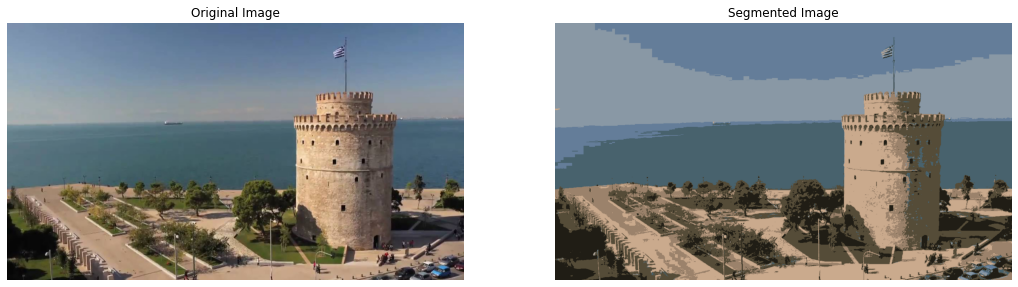

Cluster centers that you obtain after K-Means:
Cluster 0: [137 152 165]
Cluster 1: [ 72  98 109]
Cluster 2: [85 76 56]
Cluster 3: [100 125 153]
Cluster 4: [155 130 107]
Cluster 5: [202 170 141]
Cluster 6: [32 29 21]


In [14]:
img = cv2.imread('white-tower.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# initialization
features = createDataset(img)
nclusters = 7
np.random.seed(5)
index = np.random.randint(features.shape[0], size=nclusters)
centers = features[index, :]

# k-means
classes, centers = kMeansCluster(features, centers)
img_seg = mapValues(img, classes, centers)

# plot
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Segmented Image')
plt.imshow(img_seg)
plt.axis('off')
plt.show()

print('Cluster centers that you obtain after K-Means:')
for i, c in enumerate(centers):
    print('Cluster %d:' %i, c)

Problem 4. Semantic Segmentation

1. Please complete the FCN network, the fcn8s in ptsemseg/models/fcn.py. Briefly describe the model structure.

The model structure of the FCN network is a classification networks with fully connected layers into convolution layers to enables a classification net to output a heatmap.

2. Do we use weights from a pre-trained model, or do we train the model from scratch?

Weights in pre-trained model were used.

3. Please train the network with CityScape dataset. Visualize the training curves (suggested option: use Tensorboard). Include pictures of the training and validation curve. (config file: configs/fcn8s_cityscapes.yml)

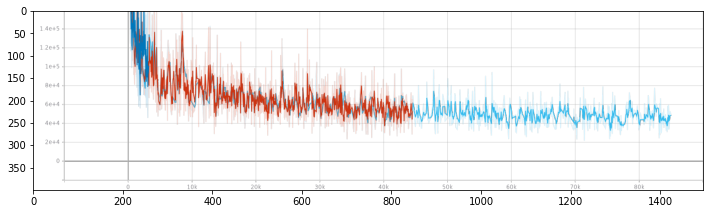

In [15]:
train_loss = plt.imread('train_loss.png')

plt.figure(figsize=(12,9))
plt.imshow(train_loss)

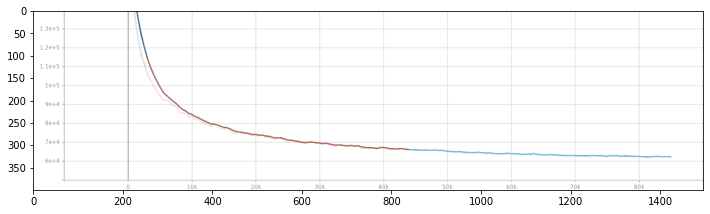

In [16]:
val_loss = plt.imread('val_loss.png')

plt.figure(figsize=(12,9))
plt.imshow(val_loss)

4. What are the metrics used by the original paper? Do inference (validate.py) on the valida-
tion set. Which classes work well? Which classes do not?

The following metrices are used in paper:
a. pixel accuracy
b. mean accuracy
c. mean IU
d. frequency weighted IU

In IOU, classes 0, 1, 2, 8, 10, 13 work well - IOU over 0.4
The rest of classes didn't work well in the same criteria.

5. Can you visualize your results, by plotting out the labels and predictions of the images? Please include at least two examples (HINT: check the unit test in ptsemseg/loader/cityscapes loader.py)

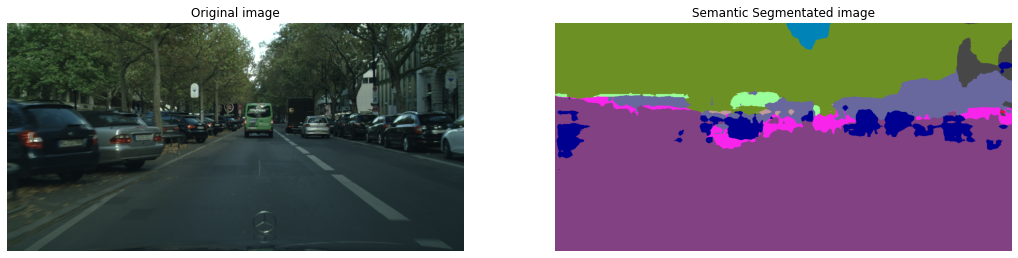

In [17]:
test = plt.imread('berlin_000019_000019_leftImg8bit.png')
mask = plt.imread('berlin_019_mask.png')

plt.figure(figsize=(18,10))
plt.subplot(121)
plt.imshow(test)
plt.title('Original image')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Semantic Segmentated image')
plt.axis('off')

plt.show()

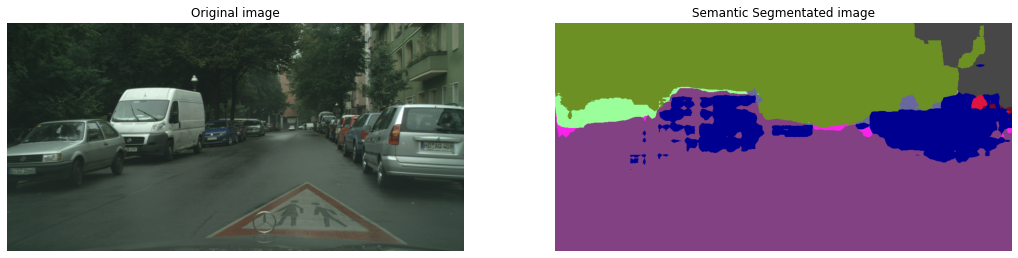

In [18]:
test = plt.imread('berlin_000229_000019_leftImg8bit.png')
mask = plt.imread('berlin_229_mask.png')

plt.figure(figsize=(18,10))
plt.subplot(121)
plt.imshow(test)
plt.title('Original image')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Semantic Segmentated image')
plt.axis('off')

plt.show()

6. Take a photo of a nearby city street, and show the output image from the model. Does the output image look reasonable?

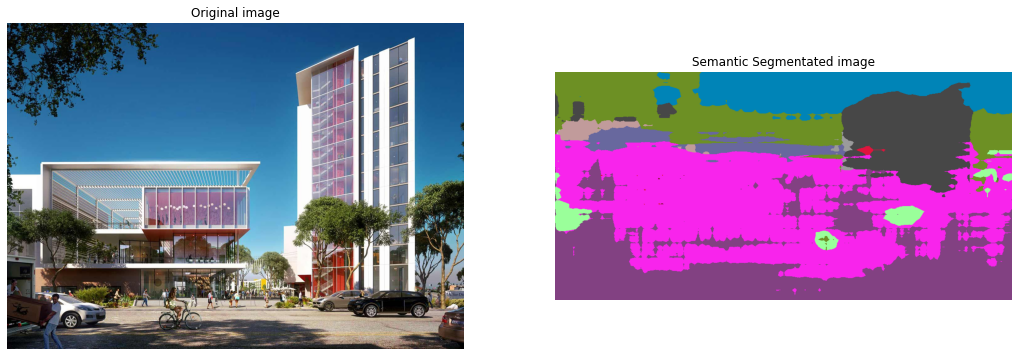

In [19]:
test = plt.imread('street.jpg')
mask = plt.imread('test_mask.png')

plt.figure(figsize=(18,10))
plt.subplot(121)
plt.imshow(test)
plt.title('Original image')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Semantic Segmentated image')
plt.axis('off')

plt.show()

I think road part of image mask was good. The overall horizon shape of buildings, street, and sky was captured. But the vehicle parts are not predicted very well.

7. Based on your analysis of the model and training, how can you get better results for prediction? (Give 2 possible options. Change the parameters? Change the network architecture? Or other thoughts? You can checkout the FCN paper [1] and the followup works.)

We can change diiferent pre-trained model except for VGG model in this paper. Also, according to the paper, change the hyperparameters in each layer in CNN might help, e.g. strides or kernel size. Train on more "varied" dataset might work as well, since different dataset provide different properties of images, e.g. histogram. My test image is much brighter than "berlin street" in cityscapes dataset, so it might cause difference in performance.

In [20]:
def Tritongram(image, filter):
    if filter == 'Edges':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        sobel_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype = np.float32)
        sobel_y = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype = np.float32)

        img_pad = np.pad(image, (1, 1), mode = 'reflect')
        img_Gx = cv2.filter2D(img_pad, -1, sobel_x)
        img_Gy = cv2.filter2D(img_pad, -1, sobel_y)
        img_G = np.sqrt(img_Gx ** 2 + img_Gy ** 2)
        img_G *= 255 / np.max(img_G)
        res = img_G
    elif filter == 'Obscure':
        kern = 1 / 225 * np.ones((15,15))
        res = cv2.filter2D(img, -1, kern)
    elif filter == 'Color_reverse':
        res = 255 * np.ones(image.shape) - image

    return res

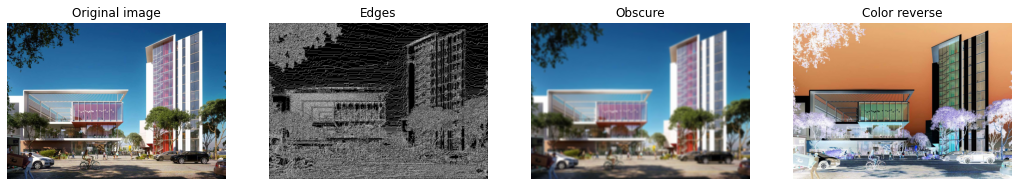

In [21]:
img = plt.imread('street.jpg')

plt.figure(figsize=(18,18))
plt.subplot(141)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(142)
plt.imshow(Tritongram(img, 'Edges').astype(int), cmap = 'gray')
plt.title('Edges')
plt.axis('off')

plt.subplot(143)
plt.imshow(Tritongram(img, 'Obscure').astype(int), )
plt.title('Obscure')
plt.axis('off')

plt.subplot(144)
plt.imshow(Tritongram(img, 'Color_reverse').astype(int))
plt.title('Color reverse')
plt.axis('off')

plt.show()